<a href="https://colab.research.google.com/github/gptix/DS-Unit-2-Applied-Modeling/blob/master/module3/Jud_Taylor_assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

-

---

-

**I copied my data set from Monday, since yesterday I played with the Condos dataset.**

-

----



I got a baseline metric, some accuracy scores, ran tree classifications, and calculated and visualized ROC curves.

I still need to 
- Try xgboost.
- Get your model's permutation importances.



# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Question: **Is this mushroom poisonous?**

Data set: https://archive.ics.uci.edu/ml/datasets/mushroom

**This is NOT one of the most popular UCI datasets.**

## Ingest Data

In [0]:
%%capture
import sys

# If Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/gptix/Project2/master/'
    !pip install category_encoders==2.*

# If local:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# I extracted these column names from the text file 
# https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
# I added the column 'poisonous', which was unlabeled in the original set.

colnames = ['poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?',
            'odor', 'gill-attachment', 'gill-spacing', 'gill-size',
            'gill-color', 'stalk-shape', 'stalk-root', 
            'stalk-surface-above-ring', 'stalk-surface-below-ring',
            'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
            'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 
            'population', 'habitat']

filename = 'agaricus-lepiota.data?token=AFCZYWEJZMR7ABZFRB62GKK6AEJIM'

df = pd.read_csv(DATA_PATH + filename, header=None, names=colnames)
df.shape

(8124, 23)

## Make Backup for backup and restore

In [0]:
df_bak = df

In [0]:
# df = df_bak

## Examine Data

In [0]:
df.head()
# examine data

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


## Select Target (and feature)

In [0]:
# I choose to predict 'poisonous'.
target = 'poisonous'

features = list(set(colnames) - set([target]))

print(features)
y = df[target]
y.describe()

features

['spore-print-color', 'ring-type', 'habitat', 'veil-color', 'stalk-color-below-ring', 'cap-surface', 'ring-number', 'cap-color', 'veil-type', 'gill-spacing', 'stalk-surface-above-ring', 'stalk-color-above-ring', 'cap-shape', 'gill-color', 'gill-attachment', 'stalk-root', 'gill-size', 'odor', 'population', 'stalk-surface-below-ring', 'stalk-shape', 'bruises?']


['spore-print-color',
 'ring-type',
 'habitat',
 'veil-color',
 'stalk-color-below-ring',
 'cap-surface',
 'ring-number',
 'cap-color',
 'veil-type',
 'gill-spacing',
 'stalk-surface-above-ring',
 'stalk-color-above-ring',
 'cap-shape',
 'gill-color',
 'gill-attachment',
 'stalk-root',
 'gill-size',
 'odor',
 'population',
 'stalk-surface-below-ring',
 'stalk-shape',
 'bruises?']

## Decide Regression/Classification

The problem is most intuitively one of **classification**.

I might also build a **predicted probability** model.

## How is your target distributed?

Classification: 
- How many classes? **Two**:
  - poisonous
  - edible

- Are the classes imbalanced? **They are eerily balanced.**

In [0]:
y.value_counts(normalize=True).max()

0.517971442639094

In [0]:
# Derive binary classifiction target:
df['poisonous'] = df['poisonous'] == 'p'

In [0]:
df['poisonous'].value_counts()

False    4208
True     3916
Name: poisonous, dtype: int64

In [0]:
df.columns

Index(['poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?',
       'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [0]:
# examine columns
df.groupby('cap-shape')['cap-shape'].count()

cap-shape
b     452
c       4
f    3152
k     828
s      32
x    3656
Name: cap-shape, dtype: int64

## Convert single characters to strings.

This is to aid viewing.

These will be encoded back into numbers in a pipeline later.

In [0]:
df['cap-shape'] = df['cap-shape'].map({'b' : 'bell', 'c' : 'conical', 'x' : 'convex', 'f' : 'flat', 'k' : 'WYknobbed', 's' : 'sunken'})
df['cap-surface'] = df['cap-surface'].map({'f' : 'fibrous', 'g' : 'grooves', 'y' : 'scaly', 's' : 'smooth'})
df['cap-color'] = df['cap-color'].map({'n' : 'brown', 'b' : 'buff', 'c' : 'cinnamon', 'g' : 'gray', 'r' : 'green', 'p' : 'pink', 'u' : 'purple', 'e' : 'red', 'w' : 'white', 'y' : 'yellow'})
df['bruises?'] = df['bruises?'].map({'t' : 'bruises', 'f' : 'no'})
df['odor'] = df['odor'].map({'a' : 'almond', 'l' : 'anise', 'c' : 'creosote', 'y' : 'fishy', 'f' : 'foul', 'm' : 'musty', 'n' : 'none', 'p' : 'pungent', 's' : 'spicy'})
df['gill-attachment'] = df['gill-attachment'].map({'a' : 'attached', 'd' : 'descending', 'f' : 'free', 'n' : 'notched'})
df['gill-spacing'] = df['gill-spacing'].map({'c' : 'close', 'w' : 'crowded', 'd' : 'distant'})
df['gill-size'] = df['gill-size'].map({'b' : 'broad', 'n' : 'narrow'})
df['gill-color'] = df['gill-color'].map({'k' : 'black', 'n' : 'brown', 'b' : 'buff', 'h' : 'chocolate', 'g' : 'gray', 'r' : 'green', 'o' : 'orange', 'p' : 'pink', 'u' : 'purple', 'e' : 'red', 'w' : 'white', 'y' : 'yellow'})
df['stalk-shape'] = df['stalk-shape'].map({'e' : 'enlarging', 't' : 'tapering'})
df['stalk-root'] = df['stalk-root'].map({'b' : 'bulbous', 'c' : 'club', 'u' : 'cup', 'e' : 'equal', 'z' : 'rhizomorphs', 'r' : 'rooted', '?' : 'missing'})
df['stalk-surface-above-ring'] = df['stalk-surface-above-ring'].map({'f' : 'fibrous', 'y' : 'scaly', 'k' : 'silky', 's' : 'smooth'})
df['stalk-surface-below-ring'] = df['stalk-surface-below-ring'].map({'f' : 'fibrous', 'y' : 'scaly', 'k' : 'silky', 's' : 'smooth'})
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].map({'n' : 'brown', 'b' : 'buff', 'c' : 'cinnamon', 'g' : 'gray', 'o' : 'orange', 'p' : 'pink', 'e' : 'red', 'w' : 'white', 'y' : 'yellow'})
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].map({'n' : 'brown', 'b' : 'buff', 'c' : 'cinnamon', 'g' : 'gray', 'o' : 'orange', 'p' : 'pink', 'e' : 'red', 'w' : 'white', 'y' : 'yellow'})
df['veil-type'] = df['veil-type'].map({'p' : 'partial', 'u' : 'universal'})
df['veil-color'] = df['veil-color'].map({'n' : 'brown', 'o' : 'orange', 'w' : 'white', 'y' : 'yellow'})
df['ring-number'] = df['ring-number'].map({'n' : 'none', 'o' : 'one', 't' : 'two'})
df['ring-type'] = df['ring-type'].map({'c' : 'cobwebby', 'e' : 'evanescent', 'f' : 'flaring', 'l' : 'large', 'n' : 'none', 'p' : 'pendant', 's' : 'sheathing', 'z' : 'zone'})
df['spore-print-color'] = df['spore-print-color'].map({'k' : 'black', 'n' : 'brown', 'b' : 'buff', 'h' : 'chocolate', 'r' : 'green', 'o' : 'orange', 'u' : 'purple', 'w' : 'white', 'y' : 'yellow'})
df['population'] = df['population'].map({'a' : 'abundant', 'c' : 'clustered', 'n' : 'numerous', 's' : 'scattered', 'v' : 'several', 'y' : 'solitary'})
df['habitat'] = df['habitat'].map({'g' : 'grasses', 'l' : 'leaves', 'm' : 'meadows', 'p' : 'paths', 'u' : 'urban', 'w' : 'waste', 'd' : 'woods'})

df.head()


,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,True,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,False,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,False,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,True,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,False,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


## Choose your evaluation metric(s).

Classification: Is your majority class frequency >= 50% and < 70% ?

 **Yes**. 

If so, you can just use accuracy if you want. 


I'll use **accuracy**.

I'll want to use **precision**, since the cost of a false negative is high.

Choose which observations you will use to train, validate, and test your model.

Are some observations outliers? 

Will you exclude them?

Will you do a random split or a time-based split?  

**My data set has no time component.**  

**I'll use a random split**.


In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1984)
train, val = train_test_split(train, test_size=0.2, random_state=1984)

print(train.shape)
print(val.shape)
test.shape

(5199, 23)
(1300, 23)


(1625, 23)

Find baseline accuracy


In [0]:
df['stalk-root'].unique()

array(['equal', 'club', 'bulbous', 'rooted', 'missing'], dtype=object)

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# target - 'poisonous' # defined above
# features # defined above

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)

print('Validation Accuracy: ', pipeline.score(X_val, y_val))

Validation Accuracy:  0.9907692307692307


In [0]:
X_train.columns

Index(['spore-print-color', 'ring-type', 'habitat', 'veil-color',
       'stalk-color-below-ring', 'cap-surface', 'ring-number', 'cap-color',
       'veil-type', 'gill-spacing', 'stalk-surface-above-ring',
       'stalk-color-above-ring', 'cap-shape', 'gill-color', 'gill-attachment',
       'stalk-root', 'gill-size', 'odor', 'population',
       'stalk-surface-below-ring', 'stalk-shape', 'bruises?'],
      dtype='object')

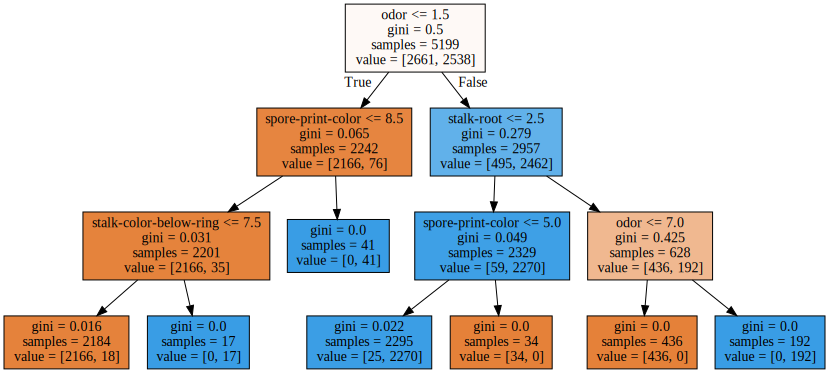

In [0]:
# Vizualize Decision Tree
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    out_file = None,
    feature_names = X_train.columns,
    # class_names = y.unique().astype(str),
    filled = True,
    # impurity=False,
    # proportion=True,
)

graphviz.Source(dot_data)

## ROC Curve

In [0]:
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
pd.DataFrame({
    'False Postivie Rate' : fpr,
    'True Positive Rate' : tpr,
    'Thresholds' : thresholds
})

,False Postivie Rate,True Positive Rate,Thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.027070,1.000000
2,0.025298,0.925159,0.974667
3,0.199405,0.995223,0.305732
4,1.000000,1.000000,0.015902


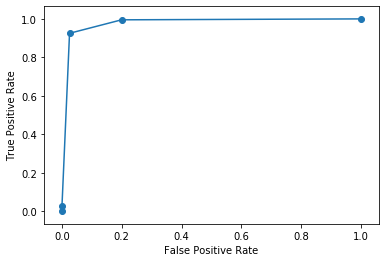

In [0]:
# Receiver Operating Chrcteristic plt
import matplotlib.pyplot as plt
plt.scatter(fpr,tpr)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9779036813770094

## Description of data:

https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names



```
# 1. Title: Mushroom Database

2. Sources: 
    (a) Mushroom records drawn from The Audubon Society Field Guide to North
        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred
        A. Knopf
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987

3. Past Usage:
    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational
       Adjustment (Technical Report 87-19).  Doctoral disseration, Department
       of Information and Computer Science, University of California, Irvine.
       --- STAGGER: asymptoted to 95% classification accuracy after reviewing
           1000 instances.
    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity
       and Coverage in Incremental Concept Learning. In Proceedings of 
       the 5th International Conference on Machine Learning, 73-79.
       Ann Arbor, Michigan: Morgan Kaufmann.  
       -- approximately the same results with their HILLARY algorithm    
    3. In the following references a set of rules (given below) were
	learned for this data set which may serve as a point of
	comparison for other researchers.

	Duch W, Adamczak R, Grabczewski K (1996) Extraction of logical rules
	from training data using backpropagation networks, in: Proc. of the
	The 1st Online Workshop on Soft Computing, 19-30.Aug.1996, pp. 25-30,
	available on-line at: http://www.bioele.nuee.nagoya-u.ac.jp/wsc1/

	Duch W, Adamczak R, Grabczewski K, Ishikawa M, Ueda H, Extraction of
	crisp logical rules using constrained backpropagation networks -
	comparison of two new approaches, in: Proc. of the European Symposium
	on Artificial Neural Networks (ESANN'97), Bruge, Belgium 16-18.4.1997,
	pp. xx-xx

	Wlodzislaw Duch, Department of Computer Methods, Nicholas Copernicus
	University, 87-100 Torun, Grudziadzka 5, Poland
	e-mail: duch@phys.uni.torun.pl
	WWW     http://www.phys.uni.torun.pl/kmk/
	
	Date: Mon, 17 Feb 1997 13:47:40 +0100
	From: Wlodzislaw Duch <duch@phys.uni.torun.pl>
	Organization: Dept. of Computer Methods, UMK

	I have attached a file containing logical rules for mushrooms.
	It should be helpful for other people since only in the last year I
	have seen about 10 papers analyzing this dataset and obtaining quite
	complex rules. We will try to contribute other results later.

	With best regards, Wlodek Duch
	________________________________________________________________

	Logical rules for the mushroom data sets.

	Logical rules given below seem to be the simplest possible for the
	mushroom dataset and therefore should be treated as benchmark results.

	Disjunctive rules for poisonous mushrooms, from most general
	to most specific:

	P_1) odor=NOT(almond.OR.anise.OR.none)
	     120 poisonous cases missed, 98.52% accuracy

	P_2) spore-print-color=green
	     48 cases missed, 99.41% accuracy
         
	P_3) odor=none.AND.stalk-surface-below-ring=scaly.AND.
	          (stalk-color-above-ring=NOT.brown) 
	     8 cases missed, 99.90% accuracy
         
	P_4) habitat=leaves.AND.cap-color=white
	         100% accuracy     

	Rule P_4) may also be

	P_4') population=clustered.AND.cap_color=white

	These rule involve 6 attributes (out of 22). Rules for edible
	mushrooms are obtained as negation of the rules given above, for
	example the rule:

	odor=(almond.OR.anise.OR.none).AND.spore-print-color=NOT.green

	gives 48 errors, or 99.41% accuracy on the whole dataset.

	Several slightly more complex variations on these rules exist,
	involving other attributes, such as gill_size, gill_spacing,
	stalk_surface_above_ring, but the rules given above are the simplest
	we have found.


4. Relevant Information:
    This data set includes descriptions of hypothetical samples
    corresponding to 23 species of gilled mushrooms in the Agaricus and
    Lepiota Family (pp. 500-525).  Each species is identified as
    definitely edible, definitely poisonous, or of unknown edibility and
    not recommended.  This latter class was combined with the poisonous
    one.  The Guide clearly states that there is no simple rule for
    determining the edibility of a mushroom; no rule like ``leaflets
    three, let it be'' for Poisonous Oak and Ivy.

5. Number of Instances: 8124

6. Number of Attributes: 22 (all nominally valued)

7. Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,
                                  knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,
                                  pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,
                                  musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g,
                                  green=r,orange=o,pink=p,purple=u,red=e,
                                  white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e,
                                  rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                  pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,
                                  none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,
                                  orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n,
                                  scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,
                                  urban=u,waste=w,woods=d

8. Missing Attribute Values: 2480 of them (denoted by "?"), all for
   attribute #11.

9. Class Distribution: 
    --    edible: 4208 (51.8%)
    -- poisonous: 3916 (48.2%)
    --     total: 8124 instances
```



https://www.youtube.com/watch?time_continue=692&v=-6s2srZT4j0&feature=emb_logo
